# CS145: Project 3 | New York Taxi Tips Prediction & Classification 

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Zhaoyu Yao, yaozy12*


# Project Overview

---

Tips are very common in our daily life. In the United States, most offline consumer activities require tipping, which also includes taking taxis. When a customer takes a taxi, what are the factors that cause the passenger to be willing to tip the driver, and what factors determine the amount of tip paid by the passenger?


At this time, we use the public data "new_york_taxi_tip" on the GCP platform to take a deep dive on factors that affect passengers’ willingness to pay tips, including trip distance, trip time and fare amount, passenger amount and the way of payment, and we apply linear regression and boosting tree to make prediction on how much the tip will be. Meanwhile, logistic regression and boosting tree are used to classify and predict whether passengers choose to pay tips, and the above models are also used to predict.

In a nutshell, this project will include:

1.What’s the relationship between the customer’s willingness of paying tips between factors such as trip distance, trip time and fare amount, passenger amount and the way of payment? 

2.How can we use SQL and machine learning algorithms to realize classification and prediction?

3.What’s the performance of those machine learning algorithms?


---


# Analysis of Dataset

---

This time, we use “tlc_green_trips_2018” as our dataset to do analysis. This dataset is 1.44 GB in size and has 8,807,303 rows. 21 variables are included in the dataset, most of them are used to describe a trip’s time and location in a digital way, such as pickup time, drop off time, pickup location id. The character of our project, the amount of tip is also included in the dataset with some other variables, like the amount of fare, payment type to measure payment behavior.

----

Firstly, we need to setup the location and bigquery autheration.

In [ ]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
project_id = "cs145-fa21-328321"

In [ ]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [ ]:
# Run this cell to create a dataset to store your model, or create in the UI 
model_dataset_name = 'new_york_green_taxi_tip'
dataset = bigquery.Dataset(client.dataset(model_dataset_name)) 
dataset.location = 'US'
client.create_dataset(dataset)

Dataset(DatasetReference('cs145-fa21-328321', 'new_york_green_taxi_tip'))

In [ ]:
# Add imports for any visualization libraries you may need 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
%%bigquery --project $project_id

# Show the total rows in our dataset
select count(*) as tip_record_number from 
`bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018`

,tip_record_number
0,8807303


# Data Exploration

Since in this dataset, it has 21 variables, but some of them are not useful for our analysis. For example, variable “extra” means “Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges”, which means they are all same in our rows and not show difference between rows, so we can drop it from our dataset. 


As a result, we keep 9 variable, including pickup_datetime, dropoff_datetime, passenger_count, trip_distance, payment_type, tip_amount, fare_amount, total_amount, pickup_location_id, dropoff_location_id, and generate one addictive variable, trip_seconds to measure the duration of the trip, using the time difference between pickup datetime and dropoff datetime. Meanwhile, we delete all the null value.

In [ ]:
%%bigquery --project $project_id

#filter useful variables
create table cs145-fa21-328321.new_york_green_taxi_tip.dataset1 as
select pickup_datetime,dropoff_datetime,passenger_count,trip_distance,payment_type,tip_amount,fare_amount,total_amount,pickup_location_id,dropoff_location_id,
time_diff(time(dropoff_datetime),time(pickup_datetime),second) as trip_seconds from
`bigquery-public-data.new_york_taxi_trips.tlc_green_trips_2018`
where passenger_count is not null  and 
      passenger_count >=0 and
      payment_type is not null and
      fare_amount is not null and
      fare_amount >= 0 and
      total_amount is not null and
      total_amount >=0 and
      pickup_datetime is not null and
      dropoff_datetime is not null and 
      trip_distance is not null and
      trip_distance >=0 and
      dropoff_location_id is not null and 
      pickup_location_id is not null and
      tip_amount >=0 and
      tip_amount is not null


""


In [ ]:
%%bigquery --project $project_id


#Check the total rows after filtering
select count(*) as total_rows from `cs145-fa21-328321.new_york_green_taxi_tip.dataset1`

,total_rows
0,8784242


In [ ]:
%%bigquery --project $project_id

#The seconds <= 0 is not meaningful, so we just keep the duration which is positive number
 create table cs145-fa21-328321.new_york_green_taxi_tip.dataset2 as
 select * from `cs145-fa21-328321.new_york_green_taxi_tip.dataset1`
 where trip_seconds > 0

""


In [ ]:
%%bigquery --project $project_id

#Check the total rows after filtering
select count(*) as total_rows from `cs145-fa21-328321.new_york_green_taxi_tip.dataset2`

,total_rows
0,8669046


In [ ]:
%%bigquery --project $project_id 
#Check the descriptive statistics of tip_amount, including count, mean, max, min
select count(tip_amount) as number_of_tips,avg(tip_amount) as mean_of_tip_amount ,min(tip_amount) as minimum_of_tip_amount,max(tip_amount) as max_of_tip_amount from
`cs145-fa21-328321.new_york_green_taxi_tip.dataset2`

,number_of_tips,mean_of_tip_amount,minimum_of_tip_amount,max_of_tip_amount
0,8669046,1.01607247,0,485.55


In [ ]:
%%bigquery --project $project_id 
#Chech the percentile of paying tips
select countif(tip_amount != 0) as number_of_tips, countif(tip_amount != 0) /(select count(tip_amount) from `cs145-fa21-328321.new_york_green_taxi_tip.dataset2`) as percentile_of_tips
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset2`

,number_of_tips,percentile_of_tips
0,3216968,0.371087


The percentile of trips whose consumers would like to pay tips is 37%. 

In [ ]:
%%bigquery --project $project_id 
#Chech the percentile of not paying tips
select countif(tip_amount = 0) as number_of_no_tips, countif(tip_amount = 0) /(select count(tip_amount) from `cs145-fa21-328321.new_york_green_taxi_tip.dataset2`) as percentile_of_no_tips
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset2`

,number_of_no_tips,percentile_of_no_tips
0,5452078,0.628913


The percentile of trips whose consumers would not like to pay tips is 63%. 

In [ ]:
%%bigquery --project $project_id tips
select tip_amount
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset2`

Text(0.5, 1.0, 'Distribution of tip_amount(with tip=0)')

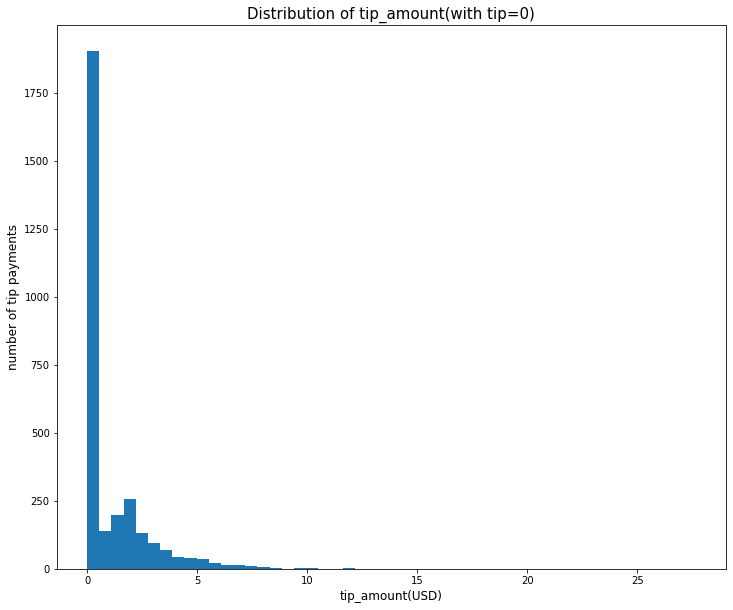

In [ ]:
tips_sub = tips.sample(3000)
plt.figure(figsize=(12,10))
x=tips_sub["tip_amount"]
plt.hist(x,bins=50)
plt.xlabel("tip_amount(USD)",fontsize=12)
plt.ylabel("number of tip payments",fontsize=12)
plt.title("Distribution of tip_amount(with tip=0)",fontsize=15)

Text(0.5, 1.0, 'Distribution of tip_amount(without tip=0)')

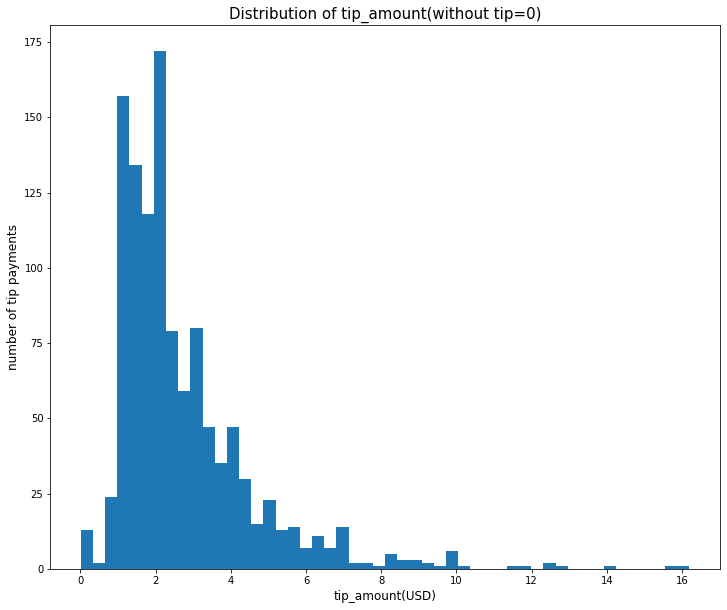

In [ ]:
tips_sub = tips.sample(3000)
plt.figure(figsize=(12,10))
y=tips_sub["tip_amount"][tips_sub["tip_amount"]>0]
plt.hist(y,bins=50)
plt.xlabel("tip_amount(USD)",fontsize=12)
plt.ylabel("number of tip payments",fontsize=12)
plt.title("Distribution of tip_amount(without tip=0)",fontsize=15)

Let's check the relationship between interesting factors and tips.

In [ ]:
%%bigquery --project $project_id 
#Consruct dataset which the amount of tip  > 0
create table cs145-fa21-328321.new_york_green_taxi_tip.dataset3 as
select * from 
`cs145-fa21-328321.new_york_green_taxi_tip.dataset2`
where tip_amount>0

""


## Tip VS Trip Distance

In [ ]:
%%bigquery --project $project_id tip_vs_tripdistance
#check the relationship between tip amount and trip distance
select trip_distance, tip_amount from 
`cs145-fa21-328321.new_york_green_taxi_tip.dataset3`

Text(0.5, 1.0, 'Tip VS Trip distance')

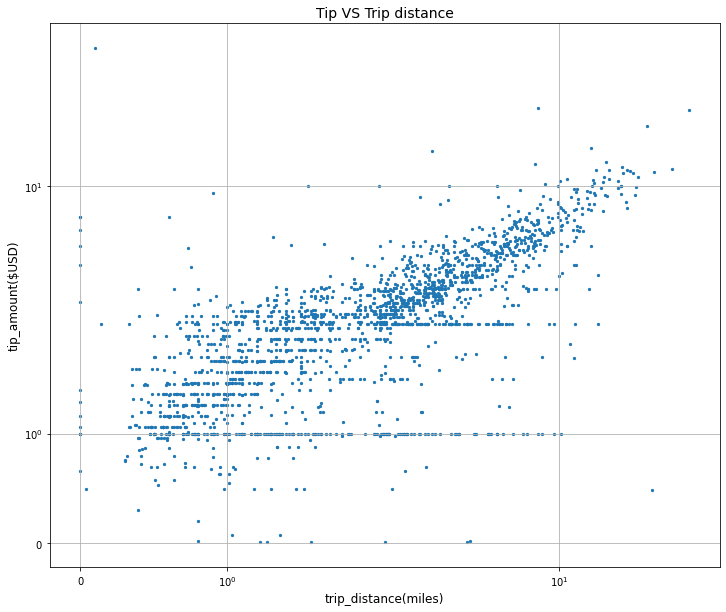

In [ ]:
#Scatter plot between tip amount and trip distance
tip_vs_tripdistance_sub = tip_vs_tripdistance.sample(2000)
plt.figure(figsize=(12,10))
y=tips_sub["tip_amount"]
x=tip_vs_tripdistance_sub["trip_distance"]
y=tip_vs_tripdistance_sub["tip_amount"]
plt.scatter(x,y,s=5)
plt.xscale("symlog")
plt.yscale("symlog")
plt.ylabel("tip_amount($USD)",fontsize=12)
plt.xlabel("trip_distance(miles)",fontsize=12)
plt.grid()
plt.title("Tip VS Trip distance",fontsize=14)

Through the scatter plot, we can see that if trip distance increases, customers will be willing to pay more tips. These two factors has a postive correlation.

## Tip VS Trip Duration

In [ ]:
#check the relationship between tip amount and trip duration
%%bigquery --project $project_id tip_vs_tripduration

select trip_seconds, tip_amount from 
`cs145-fa21-328321.new_york_green_taxi_tip.dataset3`

Text(0.5, 1.0, 'Tip VS Trip Duration')

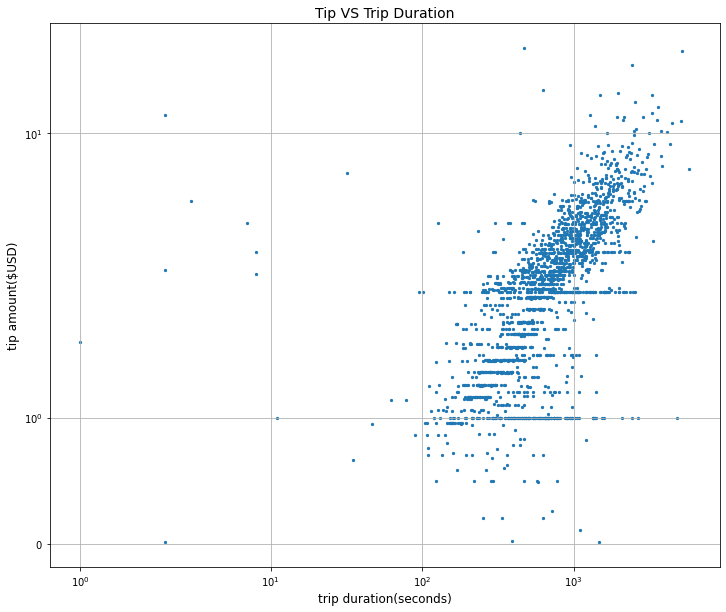

In [ ]:
#Scatter plot between tip amount and trip duration
tip_vs_tripduration_sub = tip_vs_tripduration.sample(2000)
plt.figure(figsize=(12,10))
y=tips_sub["tip_amount"]
x=tip_vs_tripduration_sub["trip_seconds"]
y=tip_vs_tripduration_sub["tip_amount"]
plt.scatter(x,y,s=5)
plt.xscale("symlog")
plt.yscale("symlog")
plt.ylabel("tip amount($USD)",fontsize=12)
plt.xlabel("trip duration(seconds)",fontsize=12)
plt.grid()
plt.title("Tip VS Trip Duration",fontsize=14)

Through the scatter plot, we can see that if trip duration increases, customers will be also willing to pay more tips. These two factors has a relatively postive correlation.

## Tip VS Fare Amount

In [ ]:
##check the relationship between tip amount and fare amount
%%bigquery --project $project_id tip_vs_tripfare

select fare_amount, tip_amount from 
`cs145-fa21-328321.new_york_green_taxi_tip.dataset3`

Text(0.5, 1.0, 'Tip VS Fare Amount ')

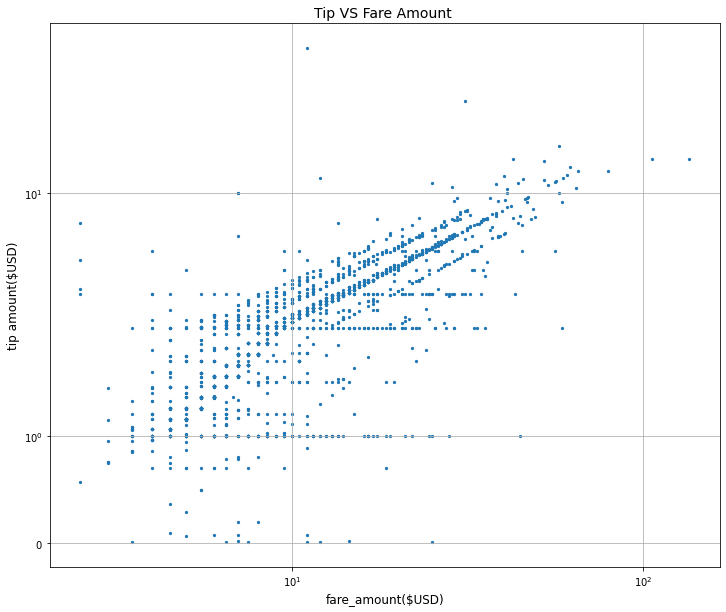

In [ ]:
#Scatter plot between tip amount and fare amount
tip_vs_tripfare_sub = tip_vs_tripfare.sample(2000)
plt.figure(figsize=(12,10))
y=tips_sub["tip_amount"]
x=tip_vs_tripfare_sub["fare_amount"]
y=tip_vs_tripfare_sub["tip_amount"]
plt.scatter(x,y,s=5)
plt.xscale("symlog")
plt.yscale("symlog")
plt.ylabel("tip amount($USD)",fontsize=12)
plt.xlabel("fare_amount($USD)",fontsize=12)
plt.grid()
plt.title("Tip VS Fare Amount ",fontsize=14)

Through the scatter plot, we can see that if fare amount increases, customers will be also willing to pay more tips. These two factors has a relatively postive correlation. Typically, customers may use a percentaile of fare amount to pay the tips, such as 10%, 20% ,etc.

## Tip VS Payment type

In [ ]:
#Check the relationship between payment_type and tips paying
%%bigquery --project $project_id paymenttype1

select payment_type, count(tip_amount) as number_of_tip_amount,avg(tip_amount) as average_tip_amount from 
`cs145-fa21-328321.new_york_green_taxi_tip.dataset2`
group by payment_type
order by payment_type

,payment_type,number_of_tip_amount,average_tip_amount
0,1,4948609,1.779874953
1,2,3683312,0.000003576
2,3,24138,0.011175325
3,4,12614,0.013776756
4,5,373,0.045764075


NOTE. The number of payment type means a numeric code signifying how the passenger paid for the trip. 1= Credit card 2= Cash 3= No charge 4= Dispute 5= Unknown 6= Voided trip

As we can see the most 2 popular way is credit card and cash. However, the average of tip for customers using credit card is 1.78 and the average of tip for customers using cash is 0.000003576, which is very close to 0, which we can guess people who use cash to make payments are more likely to choose not to pay tips. A plausible reason may be that using credit card is more convinient to pay and add tips is just to change a number on the screen.

In [ ]:
#Check the average of tips under different payment type when the tips >0
%%bigquery --project $project_id paymenttype

select payment_type, count(tip_amount) as number_of_tip_amount,avg(tip_amount) as average_tip_amount from 
`cs145-fa21-328321.new_york_green_taxi_tip.dataset3`
group by payment_type
order by payment_type

Text(0.5, 0, 'payment type')

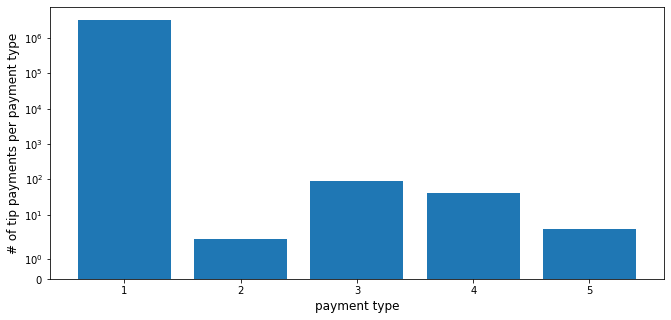

In [ ]:
plt.figure(figsize=(11,5))
plt.bar(paymenttype["payment_type"],paymenttype["number_of_tip_amount"])
plt.yscale("symlog")
plt.ylabel("# of tip payments per payment type",fontsize=12)
plt.xlabel("payment type",fontsize=12)

Through the table, it is clearly to see that people who would like to use cash to pay fare amount will more likely to refuse to pay tips.

## Tip VS Passenger Amount

In [ ]:
%%bigquery --project $project_id passenger
select passenger_count, avg(tip_amount) as avg_tip_amount from 
`cs145-fa21-328321.new_york_green_taxi_tip.dataset3`
where passenger_count>0
group by passenger_count
order by passenger_count

Text(0.5, 0, 'passenger count')

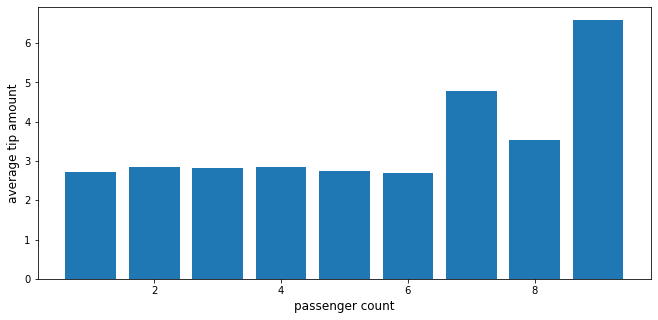

In [ ]:
plt.figure(figsize=(11,5))
plt.bar(passenger["passenger_count"],passenger["avg_tip_amount"])
plt.ylabel("average tip amount",fontsize=12)
plt.xlabel("passenger count",fontsize=12)


When passenger amount is quite big, such as 7,8,9, the average amount of tips is also more than small passenger amount. One possible reason is that when there are more passengers, they can share the tips with each other, and the amount of tips will increase, therefore.

# Model Buliding & Data Prediction

Split the dataset into training, validation and testing

In [ ]:
%%bigquery --project $project_id
#Use data between "2018-01-01" and "2018-08-31" as trainng dataset, and it has 2248408 rows.
select count(tip_amount) from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3`
where pickup_datetime between "2018-01-01" and "2018-08-31"

,f0_
0,2248408


In [ ]:
%%bigquery --project $project_id
#Use data between "2018-09-01" and "2018-10-31" as validation dataset, and it has 483849 rows.
select count(tip_amount) from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3`
where pickup_datetime between "2018-09-01" and "2018-10-31"

,f0_
0,483849


In [ ]:
%%bigquery --project $project_id
#Use data between "2018-11-01" and "2018-12-31" as testing dataset, and it has 461809 rows.
select count(tip_amount) from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3`
where pickup_datetime between "2018-11-01" and "2018-12-31"

,f0_
0,461809


# Case 1: Predict the tip amount

## Linear Regression

### MODEL 1

In [ ]:
###Model1: fare_amount (1 factor) vs tips amount using linear regression
%%bigquery --project $project_id
#Train the model
create or replace model `new_york_green_taxi_tip.nyc_tips_model_v1` 
options(model_type='linear_reg', l2_reg=1) as
select 
  log(tip_amount+1) as label,
  log(fare_amount+1) as feature1
from
`cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-01-01" and "2018-08-31"

""


In [ ]:
%%bigquery --project $project_id
select *
from
ml.training_info(model `new_york_green_taxi_tip.nyc_tips_model_v1` )

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.071991,0.068242,None,21904


In [ ]:
%%bigquery --project $project_id
#Evaluate the model
select * from
ml.evaluate(model `new_york_green_taxi_tip.nyc_tips_model_v1`, 
( select
  log(tip_amount+1) as label,
  log(fare_amount+1) as feature1
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-09-01" and "2018-10-31"))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.170739,0.07447,0.015969,0.104128,0.613727,0.613742


In this model, r2 score is 0.613727.

In [ ]:
%%bigquery --project $project_id
#Predict
select * from
ml.predict(model `new_york_green_taxi_tip.nyc_tips_model_v1` , 
( select 
  log(fare_amount+1) as feature1
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-11-01" and "2018-12-31"))
limit 10

,predicted_label,feature1
0,2.084238,3.90197267
1,2.200479,4.094344562
2,1.781644,3.401197382
3,1.984958,3.737669618
4,1.955476,3.688879454
5,2.114010,3.951243719
6,2.142384,3.998200702
7,2.566737,4.700480366
8,2.071906,3.881563798
9,1.924482,3.63758616


### MODEL 2

In [ ]:

###Model2: fare_amount,trip distance (2 factors) vs tips amount using linear regression
#Train the model
%%bigquery --project $project_id
create or replace model `new_york_green_taxi_tip.nyc_tips_model_v2` 
options(model_type='linear_reg') as
select 
  log(tip_amount+1) as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2
from
`cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-01-01" and "2018-08-31"

""


In [ ]:
%%bigquery --project $project_id
select *
from
ml.training_info(model `new_york_green_taxi_tip.nyc_tips_model_v2` )

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.071713,0.072377,None,24259


In [ ]:
%%bigquery --project $project_id
#Evaluate the model
select * from
ml.evaluate(model `new_york_green_taxi_tip.nyc_tips_model_v2`, 
( select
  log(tip_amount+1) as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-09-01" and "2018-10-31"))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.170636,0.074161,0.015845,0.104376,0.61533,0.615332


In [ ]:
%%bigquery --project $project_id
#Predict
select * from
ml.predict(model `new_york_green_taxi_tip.nyc_tips_model_v2` , 
( select 
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-11-01" and "2018-12-31"))
limit 10

,predicted_label,feature1,feature2
0,2.101889,3.90197267,2.850706502
1,2.151871,4.094344562,2.302585093
2,1.774239,3.401197382,2.066862759
3,1.980879,3.737669618,2.442347035
4,1.969444,3.688879454,2.595254707
5,2.134665,3.951243719,2.93385687
6,2.142719,3.998200702,2.753660712
7,2.535743,4.700480366,3.109060959
8,2.041152,3.881563798,2.288486169
9,1.922700,3.63758616,2.367436065


Compared with model 1, model 2's r2 score increased, but it just increased a little.

### MODEL 3

In [ ]:

###Model3: fare_amount,trip distance,trip second (3 factors) vs tips amount using linear regression
#Train the model
%%bigquery --project $project_id
create or replace model `new_york_green_taxi_tip.nyc_tips_model_v3` 
options(model_type='linear_reg') as
select 
  log(tip_amount+1) as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3
from
`cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-01-01" and "2018-08-31"

""


In [ ]:
%%bigquery --project $project_id
select *
from
ml.training_info(model `new_york_green_taxi_tip.nyc_tips_model_v3` )

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.0711,0.069865,None,22428


In [ ]:
%%bigquery --project $project_id
#Evaluate the model
select * from
ml.evaluate(model `new_york_green_taxi_tip.nyc_tips_model_v3`, 
( select
  log(tip_amount+1) as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-09-01" and "2018-10-31"))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.171344,0.073511,0.015717,0.105886,0.618702,0.618703


Compared with model 1&2, model 3's r2 score also increased, but again, it just increased a little.

In [ ]:
%%bigquery --project $project_id
#Predict
select * from
ml.predict(model `new_york_green_taxi_tip.nyc_tips_model_v3` , 
( select 
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-11-01" and "2018-12-31"))
limit 10

,predicted_label,feature1,feature2,feature3
0,2.132237,3.90197267,2.850706502,7.766417
1,2.129980,4.094344562,2.302585093,8.674710
2,1.758349,3.401197382,2.066862759,7.841100
3,1.978421,3.737669618,2.442347035,8.040769
4,1.980529,3.688879454,2.595254707,7.808729
5,2.153027,3.951243719,2.93385687,8.025843
6,2.145204,3.998200702,2.753660712,8.287528
7,2.615355,4.700480366,3.109060959,7.822044
8,2.019986,3.881563798,2.288486169,8.449557
9,1.911997,3.63758616,2.367436065,8.057694


### Linear Regression with Regulization(L2)

In [ ]:
###Model7: fare_amount,trip distance,trip second (3 factors) vs tips amount using linear regression
#Train the model
%%bigquery --project $project_id
create or replace model `new_york_green_taxi_tip.nyc_tips_model_v7` 
options(model_type='linear_reg',l2_reg=0.1) as
select 
  log(tip_amount+1) as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3
from
`cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-01-01" and "2018-08-31"

""


In [ ]:
%%bigquery --project $project_id
select *
from
ml.training_info(model `new_york_green_taxi_tip.nyc_tips_model_v7` )

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.0711,0.069865,None,23194


In [ ]:
%%bigquery --project $project_id
#Evaluate the model
select * from
ml.evaluate(model `new_york_green_taxi_tip.nyc_tips_model_v7`, 
( select
  log(tip_amount+1) as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-09-01" and "2018-10-30"))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.171309,0.073517,0.015716,0.105703,0.618708,0.618709


In [ ]:
%%bigquery --project $project_id
#Predict
select * from
ml.predict(model `new_york_green_taxi_tip.nyc_tips_model_v7` , 
( select 
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-11-01" and "2018-12-31"))
limit 10

,predicted_label,feature1,feature2,feature3
0,2.132237,3.90197267,2.850706502,7.766417
1,2.129980,4.094344562,2.302585093,8.674710
2,1.758348,3.401197382,2.066862759,7.841100
3,1.978421,3.737669618,2.442347035,8.040769
4,1.980529,3.688879454,2.595254707,7.808729
5,2.153027,3.951243719,2.93385687,8.025843
6,2.145203,3.998200702,2.753660712,8.287528
7,2.615355,4.700480366,3.109060959,7.822044
8,2.019986,3.881563798,2.288486169,8.449557
9,1.911997,3.63758616,2.367436065,8.057694


## Boosting Tree Regression

In [ ]:
###Model4: fare_amount,trip distance,trip second (3 factors) vs tips amount using boosted tree regression
#Train the model
%%bigquery --project $project_id
create or replace model `new_york_green_taxi_tip.nyc_tips_model_v4` 
options(model_type='BOOSTED_TREE_REGRESSOR') as
select
  log(tip_amount+1) as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3
from
`cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-01-01" and "2018-08-31"

""


In [ ]:
%%bigquery --project $project_id
select *
from
ml.training_info(model `new_york_green_taxi_tip.nyc_tips_model_v4` )

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,9,0.263600,0.261172,0.3,66
1,0,8,0.265621,0.262996,0.3,49
2,0,7,0.269647,0.266751,0.3,41
3,0,6,0.277631,0.274421,0.3,59
4,0,5,0.293216,0.289665,0.3,53
5,0,4,0.322643,0.318817,0.3,86
6,0,3,0.375363,0.371253,0.3,13829
7,0,2,0.464812,0.460642,0.3,58
8,0,1,0.607853,0.603741,0.3,163941


In [ ]:
%%bigquery --project $project_id
#Evaluate the model
select * from
ml.evaluate(model `new_york_green_taxi_tip.nyc_tips_model_v4`, 
( select
  log(tip_amount+1) as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-09-01" and "2018-10-31"))

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.18097,0.071935,0.015191,0.125026,0.626874,0.630825


Compared to linear regression, the performance of boosting tree model is quite cloes to linear regression model.

In [ ]:
%%bigquery --project $project_id
#Predict
select * from
ml.predict(model `new_york_green_taxi_tip.nyc_tips_model_v4` , 
( select 
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset3` 
where pickup_datetime between "2018-11-01" and "2018-12-31"))
limit 10

,predicted_label,feature1,feature2,feature3
0,2.256479,3.90197267,2.850706502,7.766417
1,2.177710,4.094344562,2.302585093,8.674710
2,1.758507,3.401197382,2.066862759,7.841100
3,2.002385,3.737669618,2.442347035,8.040769
4,1.998212,3.688879454,2.595254707,7.808729
5,2.337722,3.951243719,2.93385687,8.025843
6,2.337722,3.998200702,2.753660712,8.287528
7,2.256479,4.700480366,3.109060959,7.822044
8,2.177710,3.881563798,2.288486169,8.449557
9,1.969173,3.63758616,2.367436065,8.057694


# Case 2: Classify whether pay tips or not

First, we use whether pay the tips as catogory variable, and add payment type, passenger amount into the model.

In [ ]:
%%bigquery --project $project_id
create table cs145-fa21-328321.new_york_green_taxi_tip.dataset5 as
select *,(case when payment_type="1" then 1
              when payment_type="2" then 0
             end
)as credit_card,
         (case when tip_amount =0 then 0
           when  tip_amount > 0  then 1
             end
)as tip_or_not,
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset2` 

""


In [ ]:
%%bigquery --project $project_id
#filter the null value of payment_type
create table cs145-fa21-328321.new_york_green_taxi_tip.dataset6 as
select *
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset5` 
where credit_card is not null

""


##   Logistic Regression

In [ ]:
%%bigquery --project $project_id
#Train the model
create or replace model `new_york_green_taxi_tip.nyc_tips_model_v5` 
options(model_type='logistic_reg') as
select 
  tip_or_not as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3,
  credit_card as feature4,
  passenger_count as feature5
from
`cs145-fa21-328321.new_york_green_taxi_tip.dataset6` 
where pickup_datetime between "2018-01-01" and "2018-08-31"

""


In [ ]:
%%bigquery --project $project_id
select *
from
ml.training_info(model `new_york_green_taxi_tip.nyc_tips_model_v5` )

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,7,0.342822,0.346112,25.6,29756
1,0,6,0.349089,0.352139,12.8,30271
2,0,5,0.366975,0.369888,6.4,28667
3,0,4,0.405343,0.407242,3.2,32839
4,0,3,0.474947,0.475701,1.6,31258
5,0,2,0.557428,0.557636,0.8,29637
6,0,1,0.624776,0.624814,0.4,31851
7,0,0,0.668335,0.668337,0.2,21906


In [ ]:
%%bigquery --project $project_id
#Evaluate the model
select * from
ml.evaluate(model `new_york_green_taxi_tip.nyc_tips_model_v5`, 
( select
  tip_or_not as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3,
  credit_card as feature4,
  passenger_count as feature5
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset6` 
where pickup_datetime between "2018-09-01" and "2018-10-31"))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.61904,0.993673,0.774794,0.762843,0.392242,0.882827


Through the result, we can see the preformace of this model is quite good, recall could be close to 1.

In [ ]:
%%bigquery --project $project_id
#Predict
select * from
ml.predict(model `new_york_green_taxi_tip.nyc_tips_model_v5` , 
( select 
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3,
  credit_card as feature4,
  passenger_count as feature5
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset6` 
where pickup_datetime between "2018-11-01" and "2018-12-31"))
limit 10

,predicted_label,predicted_label_probs,feature1,feature2,feature3,feature4,feature5
0,1,"[{'label': 1, 'prob': 0.6069415936292618}, {'l...",3.36729583,2.211565695,7.576097,1,1
1,1,"[{'label': 1, 'prob': 0.6053021982907122}, {'l...",3.384390263,2.253394849,7.488294,1,1
2,1,"[{'label': 1, 'prob': 0.574522339075062}, {'la...",3.569532696,2.360854001,7.784889,1,1
3,1,"[{'label': 1, 'prob': 0.6100947580262124}, {'l...",3.349904087,2.201659174,7.447751,1,1
4,1,"[{'label': 1, 'prob': 0.5756899281997869}, {'l...",3.597312261,2.561095788,7.508787,1,1
5,1,"[{'label': 1, 'prob': 0.519025450801007}, {'la...",3.970291914,3.061520014,8.359603,1,1
6,1,"[{'label': 1, 'prob': 0.5011521228926171}, {'l...",4.006787582,2.628285233,8.213111,1,1
7,1,"[{'label': 1, 'prob': 0.528110242991602}, {'la...",3.860729711,2.624668592,8.075894,1,1
8,1,"[{'label': 1, 'prob': 0.5580510981390224}, {'l...",3.569532696,1.78339122,8.167068,1,1
9,1,"[{'label': 1, 'prob': 0.6192595519134265}, {'l...",3.277144733,2.061786606,7.394493,1,1


## Boosted Tree Classification

In [ ]:
%%bigquery --project $project_id
#Train the model
create or replace model `new_york_green_taxi_tip.nyc_tips_model_v6` 
options(model_type='BOOSTED_TREE_CLASSIFIER') as
select 
  tip_or_not as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3,
  credit_card as feature4,
  passenger_count as feature5
from
`cs145-fa21-328321.new_york_green_taxi_tip.dataset6` 
where pickup_datetime between "2018-01-01" and "2018-08-31"

""


In [ ]:
%%bigquery --project $project_id
select *
from
ml.training_info(model `new_york_green_taxi_tip.nyc_tips_model_v6` )

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,11,0.328421,0.328602,0.3,41
1,0,10,0.330304,0.331367,0.3,13640
2,0,9,0.334053,0.335009,0.3,35
3,0,8,0.338769,0.340205,0.3,12985
4,0,7,0.347585,0.347488,0.3,85
5,0,6,0.355698,0.357423,0.3,12808
6,0,5,0.370501,0.371716,0.3,77
7,0,4,0.392232,0.392288,0.3,12656
8,0,3,0.424053,0.423228,0.3,12754
9,0,2,0.469789,0.470906,0.3,52


In [ ]:
%%bigquery --project $project_id
#Evaluate the model
select * from
ml.evaluate(model `new_york_green_taxi_tip.nyc_tips_model_v6`, 
( select
  tip_or_not as label,
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3,
  credit_card as feature4,
  passenger_count as feature5
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset6` 
where pickup_datetime between "2018-09-01" and "2018-10-31"))

,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.679732,0.902737,0.809508,0.775521,0.366973,0.893719


Compared to the logistic regression model, boosting tree model increased the accuracy.

In [ ]:
%%bigquery --project $project_id
#Predict
select * from
ml.predict(model `new_york_green_taxi_tip.nyc_tips_model_v6` , 
( select 
  log(fare_amount+1) as feature1,
  log(trip_distance+1) as feature2,
  log(trip_seconds+1) as feature3,
  credit_card as feature4,
  passenger_count as feature5
from `cs145-fa21-328321.new_york_green_taxi_tip.dataset6` 
where pickup_datetime between "2018-11-01" and "2018-12-31"))
limit 10

,predicted_label,predicted_label_probs,feature1,feature2,feature3,feature4,feature5
0,0,"[{'label': 1, 'prob': 0.44017431139945984}, {'...",3.417726684,1.40854497,8.050703,1,1
1,0,"[{'label': 1, 'prob': 0.1511778086423874}, {'l...",4.356708827,3.17805383,8.464636,1,1
2,1,"[{'label': 1, 'prob': 0.6465254426002502}, {'l...",3.277144733,2.163323026,7.257708,1,1
3,1,"[{'label': 1, 'prob': 0.6582226157188416}, {'l...",3.314186005,2.302585093,7.118016,1,5
4,0,"[{'label': 1, 'prob': 0.41532447934150696}, {'...",3.295836866,1.931521412,7.758333,1,1
5,1,"[{'label': 1, 'prob': 0.6136719584465027}, {'l...",3.349904087,2.332143895,7.201916,1,4
6,1,"[{'label': 1, 'prob': 0.6971041560173035}, {'l...",3.277144733,2.228938553,6.983790,1,1
7,0,"[{'label': 1, 'prob': 0.3767896294593811}, {'l...",3.583518938,2.305580602,7.896925,1,1
8,0,"[{'label': 1, 'prob': 0.1511778086423874}, {'l...",4.248495242,3.250374492,8.198089,1,1
9,1,"[{'label': 1, 'prob': 0.5353595018386841}, {'l...",3.433987204,2.370243741,7.384610,1,1


# Conclusion

---

In conclusion, in this project, we firstly deep dive into the dataset, find out relationship and correlation between tip amount and some important factors. Then, we use several machine learning algorithms to make prediction on tip amount and make classification on whether paying tips or not.

Firstly, we found trip distance, trip second and fare amount all have a relatively positive correlation with the amount of tip. Meanwhile, customers using credit card to pay fare are more willing to pay tips then those using cash. When passenger amount is quite big, such as 7,8,9, the average amount of tips is also more than small passenger amount. One possible reason is that when there are more passengers, they can share the tips with each other, and the amount of tips will increase, therefore.

Through the prediction model, we use linear regression and boosting regression, however the performance is quite close between each model (R2 score are all close to 0.62). This performace is not bad, but still have a lot of space to improve.One possible reason is that maybe the correlation between these 3 factors in our regression model is a little bit high.

What about the classification model to tell us whether the customer would like to pay tips or not?
For the logistic model, the accuracy is 0.77 and boosting model has 0.8 accuracy, both are relatively good.

More i thought now and will do in the future: 
1.try to use different classification way (like DNN) in order to try to increase the model's accuracy.

2.try to do better feature engineering on the factors of linear model, especially the independent variables, and hope to improve model's preformance.

---